In [1]:
# %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# Reflect Tables into SQLAlchemy ORM

In [12]:
# reflect an existing database into a new model
# Create automap base
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)


In [13]:
# View all of the classes that automap found
table_names = list(Base.classes.keys())

print(table_names)

['measurement', 'station']


In [14]:
# Save references to each table
# Save references to the classes
station = Base.classes.station
measurement = Base.classes.measurement

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [17]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()

most_recent_date

'2017-08-23'

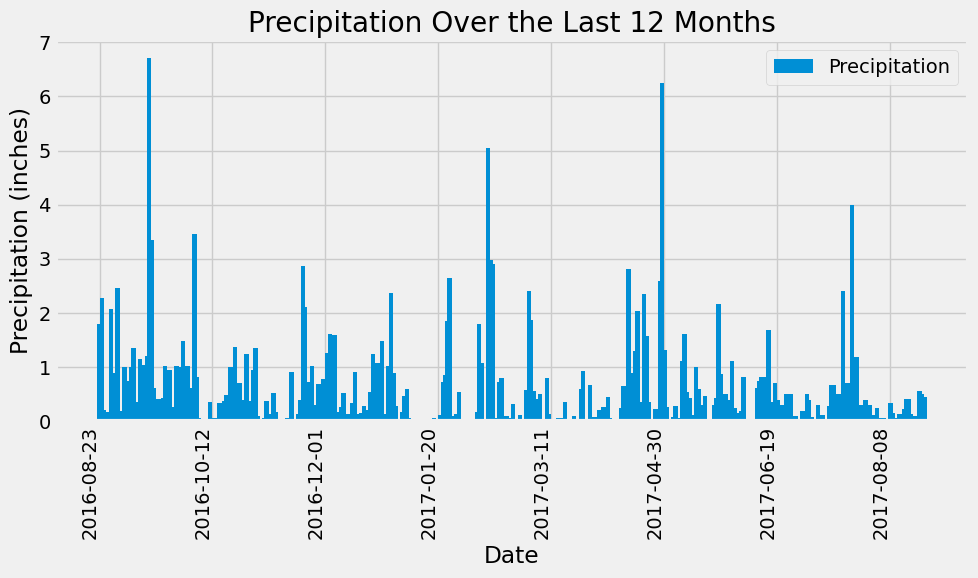

In [32]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# convert to datetime if most_recent_date is not already a datetime
if not isinstance(most_recent_date, dt.datetime):
    most_recent_date = dt.datetime.strptime(str(most_recent_date), '%Y-%m-%d').date()
# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp)\
    .filter(measurement.date >= one_year_ago)\
    .filter(measurement.date <= most_recent_date)\
    .all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(df['Date'], df['Precipitation'], label='Precipitation', width = 2.0)
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=90, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(prune='both'))
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df.describe()
summary_statistics

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [33]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count()).select_from(Base.classes.station).scalar()
station_count

9

In [35]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(measurement.station, func.count().label('observation_count'))\
    .group_by(measurement.station)\
    .order_by(func.count().desc())\
    .all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [39]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# take only most active station
most_active_station = session.query(measurement.station)\
    .group_by(measurement.station)\
    .order_by(func.count().desc())\
    .limit(1)\
    .scalar()

# calc 
temperature_stats = session.query(func.min(measurement.tobs).label('min_temperature'),
                                  func.max(measurement.tobs).label('max_temperature'),
                                  func.avg(measurement.tobs).label('avg_temperature'))\
    .filter(measurement.station == most_active_station)\
    .first()

temperature_stats

(54.0, 85.0, 71.66378066378067)

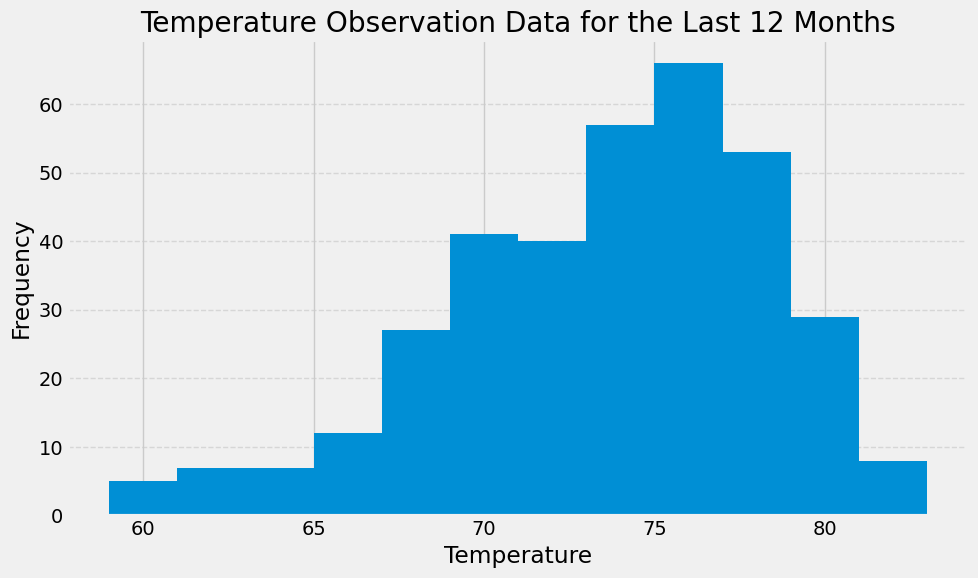

In [47]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# format date requirements
most_recent_date = session.query(func.max(measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(str(most_recent_date), '%Y-%m-%d').date()
one_year_ago = most_recent_date - dt.timedelta(days=365)

# retrive relevant data
temperature_data = session.query(measurement.tobs)\
    .filter(measurement.station == most_active_station)\
    .filter(measurement.date >= one_year_ago)\
    .filter(measurement.date <= most_recent_date)\
    .all()

# print results
temperature_data

# create dataFrame
temp_df = pd.DataFrame(temperature_data, columns=['Temperature'])

# create and plot histogram
plt.figure(figsize=(10, 6))
plt.hist(temp_df['Temperature'], bins=12, alpha=1.0)
plt.title('Temperature Observation Data for the Last 12 Months')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Close Session

In [48]:
# Close Session
session.close()